<h1><center>Дослідження генерації кіно-сценарію на основі тексту художньої книги</center></h1>

## Зміст:
1. [Попередній аналіз](#first-bullet)

2. [Очистка даних](#second-bullet)

3. [Feature-інженерінг](#third-bullet)

4. [TF-IDF](#fourth-bullet)

5. [Нейронна мережа](#fifth-bullet)





В цій роботі ми спробуємо розробити систему, яка допоможе компаніям при створенні кінофільмів на основі художніх книг.

Наша наукова робота складається зі вступу, шести розділів, висновків та списку використаної літератури. У вступі ми обґрунтували актуальність та практичну цін-ність обраної нами теми, поставили мету і завдання дослідження, зазначили методи та вказали предмет й об’єкт нашої праці.

Завантажимо необхідні бібліотеки:

In [1]:
import numpy as np
import pandas as pd
import string
import spacy

from matplotlib.pyplot import imread
from matplotlib import pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

### I. Почнемо наш аналіз з попереднього перегляду даних: <a class="anchor" id="first-bullet"></a>

In [2]:
import os
for dirname, _, filenames in os.walk('D:\\backup\\СА-32\\Курсова (машинне навчання)\\'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

D:\backup\СА-32\Курсова (машинне навчання)\1.png
D:\backup\СА-32\Курсова (машинне навчання)\Coursework_automated_screenplay_generation_presentation1.pptx
D:\backup\СА-32\Курсова (машинне навчання)\Coursework_automated_screenplay_generation_presentation2.pptx
D:\backup\СА-32\Курсова (машинне навчання)\data.csv
D:\backup\СА-32\Курсова (машинне навчання)\data.tsv
D:\backup\СА-32\Курсова (машинне навчання)\data.xlsx
D:\backup\СА-32\Курсова (машинне навчання)\data1.tsv
D:\backup\СА-32\Курсова (машинне навчання)\data2.tsv
D:\backup\СА-32\Курсова (машинне навчання)\data3.tsv
D:\backup\СА-32\Курсова (машинне навчання)\don.jpg
D:\backup\СА-32\Курсова (машинне навчання)\don1.png
D:\backup\СА-32\Курсова (машинне навчання)\Puzo Mario-The Godfather-Script.txt
D:\backup\СА-32\Курсова (машинне навчання)\Puzo Mario-The Godfather.txt
D:\backup\СА-32\Курсова (машинне навчання)\scenario_generation_on_book_ipynb.html
D:\backup\СА-32\Курсова (машинне навчання)\The Godfather.html
D:\backup\СА-32\Курсова (ма

In [3]:
filename = 'D:\\backup\\СА-32\\Курсова (машинне навчання)\\Puzo Mario-The Godfather.txt'
with open(filename, "r", encoding="UTF-8") as f:
    book = f.readlines()

In [4]:
len(book)

5821

Переглянемо перший десяток символів, які можна буде викинути, бо вони не впливають на зміст.

In [5]:
book[0:12]

['The Godfather\n',
 '\n',
 'by Mario Puzo\n',
 '\n',
 'For Anthony Cleri\n',
 '\n',
 '\n',
 '\n',
 '\n',
 'Book One \n',
 '\n',
 '\n']

### II. Очистка даних <a class="anchor" id="second-bullet"></a>

Перш ніж застосовувати машинне навчання або статистичну модель, ми завжди повинні очистити дані. Жодна модель не дає значущих результатів із безладними даними. це процес виявлення та виправлення (або видалення) пошкоджених або неточних записів із набору записів, таблиці або бази даних і стосується виявлення неповних, неправильних, неточних або нерелевантних частин даних, а потім заміни, модифікації або видалення брудних або грубі дані.

На щастя, книга, як правило, вже є чистим документом, який переглядає перевірку правопису, редагування, огляд граматики тощо. Отже, слова та речення, які ми отримуємо, зазвичай без помилок і читаються. На відміну від відповідей в деяких анкетах, де люди можуть писати що завгодно і робити багато помилок, навіть якщо не хочуть. Але все-таки є деякі зайві частини тексту, які нам не потрібні в нашому аналізі, тож давайте перейдемо до них.

#### 1. Порожні рядки

Нам не потрібні порожні рядки або порожній рядок у нашому тексті, оскільки вони не містять жодної інформації. Тому найпростіше видалити їх на початку.

In [6]:
# видаляємо міжрядкові пропуски

book = [x.strip() for x in book]

# видаляємо порожні символи, оскільки Python-ом вони сприймаються за False

book = [x for x in book if x]
book[4:10]

['Chapter 1',
 'Behind every great fortune there is a crime.',
 'Balzac',
 'Amerigo Bonasera sat in New York Criminal Court Number 3 and waited for justice; vengeance on the men who had so cruelly hurt his daughter, who had tried to dishonor her.',
 'The judge, a formidably heavy-featured man, rolled up the sleeves of his black robe as if to physically chastise the two young men standing before the bench. His face was cold with majestic contempt. But there was something false in all this that Amerigo Bonasera sensed but did not yet understand.',
 '“You acted like the worst kind of degenerates,” the judge said harshly. Yes, yes, thought Amerigo Bonasera. Animals. Animals. The two young men, glossy hair crew cut, scrubbed clean-cut faces composed into humble contrition, bowed their heads in submission.']

#### 2. Видалення непотрібних шматків тексту з книги

Нам потрібно проаналізувати текст книги, а не автора, назву книги чи рік видання. Тому ми видалимо зайві частини з тексту для аналізу.

In [7]:
core_book = book[7:]
core_book[0:8]

['Amerigo Bonasera sat in New York Criminal Court Number 3 and waited for justice; vengeance on the men who had so cruelly hurt his daughter, who had tried to dishonor her.',
 'The judge, a formidably heavy-featured man, rolled up the sleeves of his black robe as if to physically chastise the two young men standing before the bench. His face was cold with majestic contempt. But there was something false in all this that Amerigo Bonasera sensed but did not yet understand.',
 '“You acted like the worst kind of degenerates,” the judge said harshly. Yes, yes, thought Amerigo Bonasera. Animals. Animals. The two young men, glossy hair crew cut, scrubbed clean-cut faces composed into humble contrition, bowed their heads in submission.',
 'The judge went on. “You acted like wild beasts in a jungle and you are fortunate you did not sexually molest that poor girl or I’d put you behind bars for twenty years.” The judge paused, his eyes beneath impressively thick brows flickered slyly toward the s

Об'єднаймо всі речення в єдиний текст:

In [8]:
text = ' '.join(core_book)
len(text)

939761

In [9]:
text[0:400]

'Amerigo Bonasera sat in New York Criminal Court Number 3 and waited for justice; vengeance on the men who had so cruelly hurt his daughter, who had tried to dishonor her. The judge, a formidably heavy-featured man, rolled up the sleeves of his black robe as if to physically chastise the two young men standing before the bench. His face was cold with majestic contempt. But there was something false'

#### 3. Пунктуація

Насправді розділові знаки не допомагають при перевірці слів та їх значення, тож давайте позбудемось і цього.

In [10]:
no_punc_text = text.translate(str.maketrans('', '', string.punctuation))
no_punc_text[0:550]

'Amerigo Bonasera sat in New York Criminal Court Number 3 and waited for justice vengeance on the men who had so cruelly hurt his daughter who had tried to dishonor her The judge a formidably heavyfeatured man rolled up the sleeves of his black robe as if to physically chastise the two young men standing before the bench His face was cold with majestic contempt But there was something false in all this that Amerigo Bonasera sensed but did not yet understand “You acted like the worst kind of degenerates” the judge said harshly Yes yes thought Ame'

In [11]:
len(text) - len(no_punc_text)

22312

#### 4. Stopwords

Стоп-слова - це особливий випадок слів, які працюють як наповнювач і зазвичай не мають особливого значення. Ми будемо їх вилучати пізніше, оскільки порівнюємо їх появу в тексті зі значущими словами. Але давайте подивимось, що таке стоп-слова.

In [12]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
print(stop_words)

{'hasn', 's', 'o', "you'll", 'under', 'shouldn', 'wouldn', 'she', 'this', 'further', 'should', 'themselves', 'where', 'below', "hadn't", "that'll", 'until', 'again', 'for', 'more', 'yourself', 'some', 'over', 'is', 'them', 'he', 'has', 'on', 'theirs', "it's", 'can', 'its', 'did', "won't", 'ourselves', 'a', 'd', 'couldn', 'above', "aren't", 'how', 'now', 'be', 'into', 'during', 'so', 't', 'against', 'there', 'their', 'such', 'your', 'same', 'my', 'had', 'don', 'll', 'aren', 've', 'him', 'at', 'few', 'other', 'because', 'own', 'doesn', 'after', 'no', 'if', 'what', 'and', 'very', 'needn', 'his', 'wasn', 'won', 'you', 'ain', 'himself', 'too', 'are', 'up', 'i', 'once', 'were', 'mustn', 'does', 'whom', 'here', "wasn't", 'why', 'both', 'mightn', 'about', 'y', 'out', 'than', 'weren', 'as', 'it', 'not', "needn't", 'have', 'these', 'while', 're', 'isn', 'between', 'from', 'having', 'me', 'which', 'by', 'being', "you've", 'down', 'an', 'or', 'itself', 'just', 'herself', "mustn't", 'myself', 'hadn

### III. Feature-інженерінг <a class="anchor" id="third-bullet"></a>

Feature-інженерінг - це процес створення нових змінних для даного набору даних з ідеєю підвищення точності прогнозування моделі або кращого опису набору даних.

Features можуть бути:

- числові (кількість слів у реченні)
- categorical (що це за речення?)
- boolean (Чи речення довше 50 знаків? True / False)
- порядковий (речення коротке, середнє чи довге?)

#### 1. Токенізація

Токенізація - це, по суті, розбиття фрази, речення, абзацу або цілого текстового документа на менші одиниці, такі як окремі слова чи терміни. Кожна з цих менших одиниць називається лексемами.

In [13]:
from nltk import word_tokenize

text_tokens = word_tokenize(no_punc_text)
print(text_tokens[0:50])

['Amerigo', 'Bonasera', 'sat', 'in', 'New', 'York', 'Criminal', 'Court', 'Number', '3', 'and', 'waited', 'for', 'justice', 'vengeance', 'on', 'the', 'men', 'who', 'had', 'so', 'cruelly', 'hurt', 'his', 'daughter', 'who', 'had', 'tried', 'to', 'dishonor', 'her', 'The', 'judge', 'a', 'formidably', 'heavyfeatured', 'man', 'rolled', 'up', 'the', 'sleeves', 'of', 'his', 'black', 'robe', 'as', 'if', 'to', 'physically', 'chastise']


In [14]:
len(text_tokens)

184314

Після того, як ми позначили текст лексемою, ми можемо видалити з нього стоп-слова.

In [15]:
my_stop_words = stopwords.words('english')
my_stop_words.append('the')
no_stop_tokens = [word for word in text_tokens if not word in my_stop_words]
print(no_stop_tokens[0:40])

['Amerigo', 'Bonasera', 'sat', 'New', 'York', 'Criminal', 'Court', 'Number', '3', 'waited', 'justice', 'vengeance', 'men', 'cruelly', 'hurt', 'daughter', 'tried', 'dishonor', 'The', 'judge', 'formidably', 'heavyfeatured', 'man', 'rolled', 'sleeves', 'black', 'robe', 'physically', 'chastise', 'two', 'young', 'men', 'standing', 'bench', 'His', 'face', 'cold', 'majestic', 'contempt', 'But']


In [16]:
len(no_stop_tokens)

103892

#### 2. Візуалізація (wordcloud)

Проведемо базову візуалізацію - wordcloud. Подальші рисунки будуть присутні у підпункті з TF-IDF.

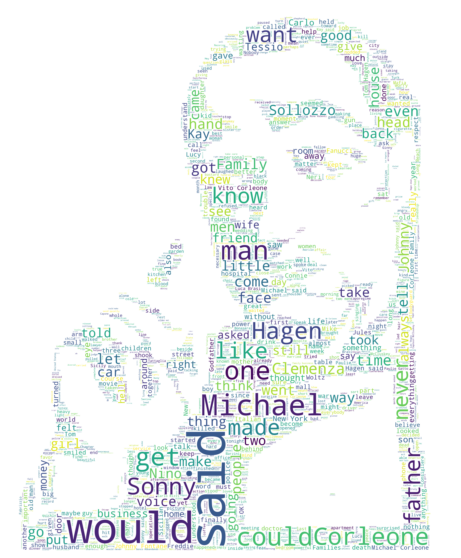

In [17]:
from PIL import Image
import numpy as np

plt.figure(figsize=(11, 10))
mask = np.array(Image.open('D:\\backup\\СА-32\\Курсова (машинне навчання)\\don.jpg'))
wc = WordCloud(stopwords=stop_words,
               mask=mask, background_color="white",
               max_words=2000, max_font_size=256,
               random_state=42, width=mask.shape[1],
               height=mask.shape[0])
wc.generate(no_punc_text)
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

#### 2. Lowercase

Щось таке просте, як написання малих літер у всіх словах, дуже допомагає, тому що перша буква в новому реченні за замовчуванням є великою, і є кілька імен людей та речей, також з великими літерами. Локалізація є стандартизацією.

In [18]:
lower_words = [x.lower() for x in no_stop_tokens]
print(lower_words[0:25])

['amerigo', 'bonasera', 'sat', 'new', 'york', 'criminal', 'court', 'number', '3', 'waited', 'justice', 'vengeance', 'men', 'cruelly', 'hurt', 'daughter', 'tried', 'dishonor', 'the', 'judge', 'formidably', 'heavyfeatured', 'man', 'rolled', 'sleeves']


У лінгвістичній морфології та пошуку інформації стемінг - це процес зведення сполучених (або іноді похідних) слів до їхніх слів основи, основи чи кореневої форми - як правило, письмової форми слова.

In [19]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()
stemmed_tokens = [ps.stem(word) for word in lower_words]
print(stemmed_tokens[0:40])

['amerigo', 'bonasera', 'sat', 'new', 'york', 'crimin', 'court', 'number', '3', 'wait', 'justic', 'vengeanc', 'men', 'cruelli', 'hurt', 'daughter', 'tri', 'dishonor', 'the', 'judg', 'formid', 'heavyfeatur', 'man', 'roll', 'sleev', 'black', 'robe', 'physic', 'chastis', 'two', 'young', 'men', 'stand', 'bench', 'hi', 'face', 'cold', 'majest', 'contempt', 'but']


#### 3. Lemmatisation

В обчислювальній лінгвістиці лематизація - це алгоритмічний процес визначення леми слова на основі передбачуваного значення. На відміну від стемінга, лематизація залежить від правильного визначення передбачуваної частини мови та значення слова в реченні, а також у межах більш широкого контексту, що оточує це речення, наприклад, сусідніх речень або навіть цілого документа. Як результат, розробка ефективних алгоритмів лематизації є відкритим напрямком досліджень.

In [20]:
# NLP-модель англійською мовою бібліотеки spacy

nlp = spacy.load('en_core_web_sm')

In [21]:
# конвертація тексту у слова з розширеними властивостями (лемми, POS)

doc = nlp(' '.join(no_stop_tokens))
print(doc[0:40])

Amerigo Bonasera sat New York Criminal Court Number 3 waited justice vengeance men cruelly hurt daughter tried dishonor The judge formidably heavyfeatured man rolled sleeves black robe physically chastise two young men standing bench His face cold majestic contempt But


In [22]:
lemmas = [token.lemma_ for token in doc]
print(lemmas[0:25])

['Amerigo', 'Bonasera', 'sit', 'New', 'York', 'Criminal', 'Court', 'Number', '3', 'wait', 'justice', 'vengeance', 'man', 'cruelly', 'hurt', 'daughter', 'try', 'dishonor', 'the', 'judge', 'formidably', 'heavyfeature', 'man', 'roll', 'sleeve']


#### 4. Підрахунок слів

Перетворимо колекцію текстових документів на матрицю підрахунку маркерів. Якщо леми є точнішими, давайте використовуватимемо їх як знак для підрахунку.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(lemmas)
X

<103924x8144 sparse matrix of type '<class 'numpy.int64'>'
	with 93090 stored elements in Compressed Sparse Row format>

In [24]:
len(vectorizer.get_feature_names())

8144

In [25]:
print(vectorizer.get_feature_names()[40:70])

['31st', '32', '35th', '48th', '4b', '5000', '55th', '90', '96th', 'a22', 'abandon', 'abbandanda', 'abbandando', 'abbandandos', 'abbandundo', 'ability', 'able', 'abort', 'abortion', 'abortionist', 'about', 'aboveboard', 'abreast', 'abruptly', 'absence', 'absently', 'absentminde', 'absentminded', 'absentmindedly', 'absolute']


In [26]:
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[0:15]

[('he', 1685),
 ('say', 1446),
 ('the', 1017),
 ('don', 941),
 ('man', 883),
 ('michael', 819),
 ('would', 771),
 ('corleone', 747),
 ('get', 737),
 ('go', 724),
 ('make', 607),
 ('hagen', 599),
 ('know', 545),
 ('come', 529),
 ('it', 505)]

#### 5. Name Entity Recognition

Розпізнавання іменованих сутностей (NER) - це, мабуть, перший крок до вилучення інформації, який спрямований на пошук і класифікацію іменованих сутностей у тексті за попередньо визначеними категоріями, такими як імена осіб, організацій, місцезнаходження, вирази часу, кількості, грошові значення, відсотки тощо. NER використовується у багатьох галузях обробки природних мов (NLP), і він може допомогти відповісти на багато реальних питань, таких як:

- Які компанії були згадані у статті новин?
- Чи зазначені товари згадувались у скаргах чи відгуках?
- Чи містить твіт ім’я людини? Чи містить твіт місцезнаходження цієї людини?

In [27]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

Одна з приємних речей про Spacy полягає в тому, що нам потрібно застосувати nlp лише один раз, весь фоновий конвеєр поверне об'єкти.

In [28]:
def _print(obj, depth):
    print(str(obj)[:depth])

In [29]:
doc = nlp(text)
_print([(X.text, X.label_) for X in doc.ents], 150)

[('Amerigo Bonasera', 'PERSON'), ('New York Criminal Court', 'ORG'), ('two', 'CARDINAL'), ('Amerigo Bonasera', 'PERSON'), ('Amerigo Bonasera', 'PERSON


In [30]:
sentences = [x for x in doc.sents]
displacy.render(nlp(str(sentences[10:20])), jupyter=True, style='ent')

### IV. TF-IDF <a class="anchor" id="fourth-bullet"></a>

Перейдемо до одного з двох основних методів вирішення нашої проблеми - алгоритму TF-IDF.

TF-IDF - це числова статистика, яка призначена для відображення того, наскільки важливим є слово для документа в колекції чи корпусі. Значення tf – idf збільшується пропорційно кількості випадків появи слова в документі та компенсується кількістю документів у корпусі, що містять слово, що допомагає скоригуватись тим, що деякі слова взагалі з’являються частіше. tf-idf - одна з найпопулярніших схем зважування термінів сьогодні. Опитування, проведене в 2015 році, показало, що 83% текстових систем рекомендацій у цифрових бібліотеках використовують tf – idf.

Term Frequency: TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document)

Inverse Document Frequency: IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

Позначимо тут речення замість слів і надамо ваги цим реченням.

In [31]:
from nltk.tokenize import sent_tokenize

sentences = sent_tokenize(text)
total_documents = len(sentences)

Ми вже проводили токенізацію, як один із складових для успішного виконання TF-IDF, раніше. Тепер створимо матрицю частот.

In [32]:
def _create_frequency_matrix(sentences):
    frequency_matrix = {}
    stopWords = set(stopwords.words("english"))
    ps = PorterStemmer()

    for sent in sentences:
        freq_table = {}
        words = word_tokenize(sent)
        for word in words:
            word = word.lower()
            word = ps.stem(word)
            if word in stopWords:
                continue

            if word in freq_table:
                freq_table[word] += 1
            else:
                freq_table[word] = 1

        frequency_matrix[sent[:15]] = freq_table

    return frequency_matrix

Виведемо створену матрицю:

In [33]:
freq_matrix = _create_frequency_matrix(sentences = sentences)

_print(freq_matrix, 200)

{'Amerigo Bonaser': {'amerigo': 1, 'bonasera': 1, 'never': 1, 'done': 1, 'finer': 1, 'work': 1, ',': 2, 'discharg': 1, 'oblig': 1, 'prepar': 2, 'hi': 1, 'old': 1, 'friend': 1, 'godfath': 1, 'lovingli'


Підрахуємо TF(t) за раніше описаною формулою:

In [34]:
def _create_tf_matrix(freq_matrix):
    tf_matrix = {}

    for sent, f_table in freq_matrix.items():
        tf_table = {}

        count_words_in_sentence = len(f_table)
        for word, count in f_table.items():
            tf_table[word] = count / count_words_in_sentence

        tf_matrix[sent] = tf_table

    return tf_matrix

Частина результуючої матриці матиме вигляд:

In [35]:
tf_matrix = _create_tf_matrix(freq_matrix = freq_matrix)

_print(tf_matrix, 500)

{'Amerigo Bonaser': {'amerigo': 0.05263157894736842, 'bonasera': 0.05263157894736842, 'never': 0.05263157894736842, 'done': 0.05263157894736842, 'finer': 0.05263157894736842, 'work': 0.05263157894736842, ',': 0.10526315789473684, 'discharg': 0.05263157894736842, 'oblig': 0.05263157894736842, 'prepar': 0.10526315789473684, 'hi': 0.05263157894736842, 'old': 0.05263157894736842, 'friend': 0.05263157894736842, 'godfath': 0.05263157894736842, 'lovingli': 0.05263157894736842, 'mother': 0.0526315789473


Якщо порівняти цю таблицю з таблицею, яку ми створили на попередньому кроці, ви побачите, що слова з однаковою частотою мають однакову оцінку TF.

Тепер порахуємо частоти кожного слова у реченнях:

In [36]:
def _create_documents_per_words(freq_matrix):
    word_per_doc_table = {}

    for sent, f_table in freq_matrix.items():
        for word, count in f_table.items():
            if word in word_per_doc_table:
                word_per_doc_table[word] += 1
            else:
                word_per_doc_table[word] = 1

    return word_per_doc_table

In [37]:
count_doc_per_words = _create_documents_per_words(freq_matrix = freq_matrix)

_print(count_doc_per_words, 500)

{'amerigo': 24, 'bonasera': 59, 'never': 304, 'done': 101, 'finer': 2, 'work': 149, ',': 4376, 'discharg': 6, 'oblig': 4, 'prepar': 32, 'hi': 2174, 'old': 197, 'friend': 174, 'godfath': 80, 'lovingli': 1, 'mother': 89, 'bride': 23, 'wed': 52, '.': 10197, 'judg': 22, 'formid': 6, 'heavy-featur': 1, 'man': 478, 'roll': 25, 'sleev': 4, 'black': 59, 'robe': 1, 'physic': 30, 'chastis': 2, 'two': 277, 'young': 141, 'men': 282, 'stand': 54, 'befor': 196, 'bench': 1, 'face': 241, 'wa': 2373, 'cold': 40,


Далі, порахуємо IDF для кожного слова та згенеруємо матрицю.

IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

In [38]:
import math

def _create_idf_matrix(freq_matrix, count_doc_per_words, total_documents):
    idf_matrix = {}

    for sent, f_table in freq_matrix.items():
        idf_table = {}

        for word in f_table.keys():
            idf_table[word] = math.log10(total_documents / float(count_doc_per_words[word]))

        idf_matrix[sent] = idf_table

    return idf_matrix

Результуюча матриця:

In [39]:
idf_matrix = _create_idf_matrix(freq_matrix = freq_matrix, count_doc_per_words = count_doc_per_words, total_documents = total_documents)

_print(idf_matrix, 500)

{'Amerigo Bonaser': {'amerigo': 2.676045494138533, 'bonasera': 2.2854047242079947, 'never': 1.5733831522413853, 'done': 2.0519353620674967, 'finer': 3.7552267401861577, 'work': 1.883070467437865, ',': 0.4151794225247647, 'discharg': 3.2781054854664955, 'oblig': 3.454196744522177, 'prepar': 2.551106757530233, 'hi': 0.7189971960998633, 'old': 1.7617905096885462, 'friend': 1.8157074875675394, 'godfath': 2.1531667488581956, 'lovingli': 4.056256735850139, 'mother': 2.106866729205226, 'bride': 2.69452


Тепер множимо значення з матриці і створюємо нову матрицю:

In [40]:
def _create_tf_idf_matrix(tf_matrix, idf_matrix):
    tf_idf_matrix = {}

    for (sent1, f_table1), (sent2, f_table2) in zip(tf_matrix.items(), idf_matrix.items()):

        tf_idf_table = {}

        for (word1, value1), (word2, value2) in zip(f_table1.items(),
                                                    f_table2.items()):  # here, keys are the same in both the table
            tf_idf_table[word1] = float(value1 * value2)

        tf_idf_matrix[sent1] = tf_idf_table

    return tf_idf_matrix

Результат наведено нижче:

In [41]:
tf_idf_matrix = _create_tf_idf_matrix(tf_matrix = tf_matrix, idf_matrix = idf_matrix)

_print(tf_idf_matrix, 500)

{'Amerigo Bonaser': {'amerigo': 0.14084449969150173, 'bonasera': 0.12028445916884181, 'never': 0.08280963959165186, 'done': 0.10799659800355245, 'finer': 0.1976435126413767, 'work': 0.09910897197041395, ',': 0.043703097107869966, 'discharg': 0.17253186765613132, 'oblig': 0.18179982865906194, 'prepar': 0.268537553424235, 'hi': 0.037841957689466486, 'old': 0.09272581629939716, 'friend': 0.09556355197723891, 'godfath': 0.11332456572937871, 'lovingli': 0.21348719662369153, 'mother': 0.11088772258974


Оцінка речення відрізняється за різними алгоритмами. Тут ми використовуємо оцінку слів Tf-IDF у реченні, щоб надати вагу абзацу.

In [42]:
def _score_sentences(tf_idf_matrix) -> dict:
    
    sentenceValue = {}

    for sent, f_table in tf_idf_matrix.items():
        total_score_per_sentence = 0

        count_words_in_sentence = len(f_table)
        for word, score in f_table.items():
            total_score_per_sentence += score

        sentenceValue[sent] = total_score_per_sentence / count_words_in_sentence

    return sentenceValue

Це дає таблицю речень та їх відповідну оцінку:

In [43]:
_print(_score_sentences(tf_idf_matrix = tf_idf_matrix), 700)

{'Amerigo Bonaser': 0.12350496550205792, 'The judge, a fo': 0.12487990365716523, 'His face was co': 0.25988669204772413, 'But there was s': 0.3070131156115828, '“You acted like': 0.0630846769443123, 'Yes, yes, thoug': 0.36204185063490685, 'Animals.': 0.6904045928938374, 'The two young m': 0.29834937061891087, 'The judge went ': 0.4977131793134315, 'He frowned and ': 0.2917556947521934, 'He spoke again.': 0.5929118231436469, '“But because of': 0.12332812278068175, 'Sentence to be ': 0.1324198680320529, 'His beautiful y': 0.123548977564992, 'It had all been': 0.9507527641833936, 'He watched the ': 0.17387590789459198, 'Oh, they were a': 0.3232586825627993, 'The black bile,': 0.1923116832656644


Як і будь-які алгоритми узагальнення, можуть бути різні способи обчислення порогового значення. Ми обчислюємо середній бал речення.

In [44]:
def _find_average_score(sentenceValue) -> int:
    
    sumValues = 0
    for entry in sentenceValue:
        sumValues += sentenceValue[entry]

    # Середнє значення для кожного речення з оригінального тексту
    average = (sumValues / len(sentenceValue))

    return average

Отримаємо середню оцінку:

In [45]:
sentence_scores = _score_sentences(tf_idf_matrix = tf_idf_matrix)

_find_average_score(sentence_scores)

0.23576135780997265

Знгенеруємо тепер підсумок тексту:

Алгоритм: Вибрати речення для узагальнення, якщо оцінка речення перевищує середній бал.

In [46]:
def _generate_summary(sentences, sentenceValue, threshold):
    sentence_count = 0
    summary = ''

    for sentence in sentences:
        if sentence[:15] in sentenceValue and sentenceValue[sentence[:15]] >= (threshold):
            summary += " " + sentence
            sentence_count += 1

    return summary

Нарешті згеренуємо підсумок:

In [47]:
summary = _generate_summary(sentences, sentence_scores, 1.5 * _find_average_score(sentence_scores))
_print(summary, 980)

 Yes, yes, thought Amerigo Bonasera. Animals. Animals. The judge went on. He spoke again. It had all been a farce. And he had prospered thereby. If she ever did come home. And paid to see it on the screen. She had misjudged his drunkenness. He sprang over the cocktail table and grabbed her by the throat. He fell on top of her. And she was giggling at him. I love your daughter with all respect. The Godfather. A respect truly earned. That you, you yourself, proclaim your friendship. His reward? He slighted no one. A maiden could do no more. They were not impressed with her. Don Corleone had no desire, no intention, of letting his youngest son be killed in the service of a power foreign to himself. He enlisted and fought over the Pacific Ocean. He became a Captain and won medals. All the guests had arrived. Her Cupid-bow mouth pouted to give him an airy kiss. She thought him incredibly handsome. He was elaborately courteous to her as if they were both actors in a play.


Цей підсумок в майбутньому допоможе нам. А зараз перейдемо до основного етапу - створення нейромережі.

### V. Нейронна мережа <a class="anchor" id="fifth-bullet"></a>

Спершу завантажимо бібліотеки і сформуємо новий датасет:

In [48]:
import pandas as pd
import csv
from sklearn.model_selection import train_test_split

Для формування датасету використаємо власний алгоритм:
- спочатку видалимо всі символи табуляції та нового рядка
- тоді поділимо на частини текст сценарію і об'єднаємо кожну стрічку частини в одну

In [49]:
f = open("D:\\backup\\СА-32\\Курсова (машинне навчання)\\Puzo Mario-The Godfather-Script.txt", "r")
data = pd.read_excel("D:\\backup\СА-32\\Курсова (машинне навчання)\\data.xlsx")

temp = f.read().splitlines()
tmp = ''
lst_tmp = lst = []
i = into = 0

for index, line in enumerate(temp):
    temp[index] = line.strip('\t')

for index, line in enumerate(temp):
    lst_tmp.append(line)

def slicee(n):
    for i in range(0, len(lst_tmp), n):
        yield lst_tmp[i:i + n]

for i in list(slicee(4)):
    a = ''.join(i)
    lst.append(a)

for index, line in enumerate(lst[3:]):
    row = pd.DataFrame({'Original': sentences[index], 'Result': line}, index=[index])
    data = data.append(row, ignore_index=False)

data.head()

,Original,Result
0,Amerigo Bonasera sat in New York Criminal Cour...,BONASERA
1,"The judge, a formidably heavy-featured man, ro...",America has made my fortune.
2,His face was cold with majestic contempt.,
3,But there was something false in all this that...,"As he speaks, THE VIEW imperceptibly begins to..."
4,"“You acted like the worst kind of degenerates,...",


#### Далі проведемо sentiment analysis.

In [50]:
from itertools import islice
import matplotlib.pyplot as plt
 
data.shape
def take(n, iterable):
    return list(islice(iterable, n))

In [51]:
affinity_scores = data['Original'].to_dict()
take(5, affinity_scores.items())

[(0,
  'Amerigo Bonasera sat in New York Criminal Court Number 3 and waited for justice; vengeance on the men who had so cruelly hurt his daughter, who had tried to dishonor her.'),
 (1,
  'The judge, a formidably heavy-featured man, rolled up the sleeves of his black robe as if to physically chastise the two young men standing before the bench.'),
 (2, 'His face was cold with majestic contempt.'),
 (3,
  'But there was something false in all this that Amerigo Bonasera sensed but did not yet understand.'),
 (4,
  '“You acted like the worst kind of degenerates,” the judge said harshly.')]

У лексиці емоцій ми лематизували, але ми хочемо показати оригінальне речення та оригінальну форму слів у результатах? Як це зробити?

Наступні кроки:

- поставити унікальний ідентифікатор у кожному реченні (рядку)
- скласти колонку до речення
- обчислити оцінку для кожного речення (рядка), перетворивши слово в лематизовану форму лише для порівняння та зберегти його в новому   стовпці
- упорядкуйте речення за балами, щоб показати 10 і 10 найнижчих

In [52]:
from nltk import tokenize
sentences = tokenize.sent_tokenize(" ".join(core_book))
sentences[5:13]

['Yes, yes, thought Amerigo Bonasera.',
 'Animals.',
 'Animals.',
 'The two young men, glossy hair crew cut, scrubbed clean-cut faces composed into humble contrition, bowed their heads in submission.',
 'The judge went on.',
 '“You acted like wild beasts in a jungle and you are fortunate you did not sexually molest that poor girl or I’d put you behind bars for twenty years.” The judge paused, his eyes beneath impressively thick brows flickered slyly toward the sallow-faced Amerigo Bonasera, then lowered to a stack of probation reports before him.',
 'He frowned and shrugged as if convinced against his own natural desire.',
 'He spoke again.']

In [53]:
sent_df = pd.DataFrame(sentences, columns=['sentence'])
sent_df

,sentence
0,Amerigo Bonasera sat in New York Criminal Cour...
1,"The judge, a formidably heavy-featured man, ro..."
2,His face was cold with majestic contempt.
3,But there was something false in all this that...
4,"“You acted like the worst kind of degenerates,..."
...,...
11378,"Washed clean of sin, a favored supplicant, she..."
11379,She shifted her body to make her weight less p...
11380,She emptied her mind of all thought of herself...
11381,Then with a profound and deeply willed desire ...


Іноді немає жодної заздалегідь визначеної функції, яка виконує все, що ми хочемо. Тому ми визначаємо власну функцію, яка є специфічною для нашого випадку використання.

In [54]:
nlp = spacy.load('en_core_web_sm')
sentiment_lexicon = affinity_scores

def calculate_sentiment(text: str = None) -> float:
    sent_score = 0
    if text:
        sentence = nlp(text)
        for word in sentence:
            sent_score += sentiment_lexicon.get(word.lemma_, 0)
    return sent_score

У нашому випадку ми хочемо оцінити кожне слово у реченні у лематизованій формі, але розрахувати оцінку для всього вихідного речення.

In [55]:
sent_df['sentiment_value'] = sent_df['sentence'].apply(calculate_sentiment)
sent_df['word_count'] = sent_df['sentence'].str.split().apply(len)
sent_df['word_count'].head(10)

sent_df.sort_values(by='sentiment_value').head(3)

,sentence,sentiment_value,word_count
0,Amerigo Bonasera sat in New York Criminal Cour...,0,31
7583,I want all cooperation with the other Families...,0,24
7584,I want nothing to break this peace no matter w...,0,21


Далі, видалимо деякі імена головних героїв, аби нейронній мережі було легше справлятися із завданням.

In [56]:
for index1, row in data.iterrows():
    a = str(row['Result'])
    s = a.strip().split()
    for c in s:
        if c.isupper() and len(s) != 1:
            data.drop(index1, axis=0, inplace=True)
            break

print('Перетворені дані:')
data.head(13)

Перетворені дані:


,Original,Result
0,Amerigo Bonasera sat in New York Criminal Cour...,BONASERA
1,"The judge, a formidably heavy-featured man, ro...",America has made my fortune.
2,His face was cold with majestic contempt.,
4,"“You acted like the worst kind of degenerates,...",
5,"Yes, yes, thought Amerigo Bonasera.",BONASERA
8,"The two young men, glossy hair crew cut, scrub...",taught her never to dishonor her
9,The judge went on.,"family. She found a boy friend,"
10,“You acted like wild beasts in a jungle and yo...,not an Italian. She went to the
11,He frowned and shrugged as if convinced agains...,"movies with him, stayed out late."
12,He spoke again.,Two months ago he took her for a


Тепер перейдемо до безпосереднього проектування мережі на основі моделі AutoModel.

In [57]:
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy
import tensorflow as tf
import autokeras as ak

X, y = data.iloc[:, 0].to_numpy(), data.iloc[:, 1].to_numpy()
print(X.shape, y.shape)

X = X.astype('object')
y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6813,) (6813,)
(4564,) (2249,) (4564,) (2249,)


Побудуємо нашу модель. AutoKeras досить гнучка для формату даних. Для тексту вхідні дані повинні бути одновимірними. 

Для цілей же регресії це повинен бути вектор числових значень. AutoKeras приймає numpy.ndarray.

In [58]:
input_node = ak.TextInput()
output_node = ak.TextBlock(block_type="ngram")(input_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=3
)

Нарешті "зафітимо" дані, а потім завантажимо tensorboard для візуалізації результатів.

In [61]:
from keras.callbacks import TensorBoard

log_dir = "C:\\Users\\danie\\OneDrive\\Документи\\vs code\\logs\\fit"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

clf.fit(X_train, 
        y_train, 
        epochs=2,
        callbacks=[tensorboard_callback])

Trial 3 Complete [00h 00m 28s]
val_loss: 6.671507835388184

Best val_loss So Far: 6.664879322052002
Total elapsed time: 00h 01m 29s
INFO:tensorflow:Oracle triggered exit
Epoch 1/2
143/143 [==============================] - 11s 51ms/step - loss: 7.6034 - accuracy: 0.1888
Epoch 2/2
143/143 [==============================] - 3s 24ms/step - loss: 5.4953 - accuracy: 0.2942
INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Тепер збережемо та переглянемо статистику нашої моделі.

In [62]:
model = clf.export_model()

model.save("model_autokeras", save_format="tf")

model.summary()

INFO:tensorflow:Assets written to: model_autokeras\assets
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 1)                 0         
_________________________________________________________________
text_vectorization (TextVect (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                160032    
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
den

Перевіримо файли log і звізуалізуємо результати роботи моделі:

In [72]:
%load_ext tensorboard
%tensorboard --logdir=log_dir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 24128), started 11:22:08 ago. (Use '!kill 24128' to kill it.)

Отже, як бачимо з візуалізації, наша точність не перевищує 30%, тобто ми створили лише часткову модель і, на жаль, не надто успішну.


Проте в парі з результатими виконання tf-idf, дасть нам можливість для подальшого дослідження в майбутньому.